# 앙상블(Ensemble)
- 다양한 모델을 경합하여 예측 성능을 향상시키는 방법
- 투표(voting), 배깅(Bagging), 부스팅(Booting), 스태킹(Stacking) 네 가지로 구분

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Voting
- hard voting : 여러 개의 예측치에 대해 다수결로 결정
- soft voting : 여러 개의 예측 확률을 평균내어 결정

##### 위스콘신 유방암 데이터셋 (Wisconsin Breast Cancer Dataset)

유방암의 악성(Malignant)과 양성(Benign)을 분류하기 위해 자주 사용되는 데이터셋
(의학적인 이미지를 바탕으로 유방암 종양의 특징을 수치화한 데이터)

**데이터셋 개요**
- **목적**: 유방암 종양이 악성(Malignant)인지, 양성(Benign)인지 분류
- **샘플 수**: 569개
- **특징(Features) 수**: 30개
- **타겟(Target)**: 0(악성) 또는 1(양성)

**데이터 구성**
1. **Radius mean**: 종양의 평균 반지름
2. **Texture mean**: 종양의 표면의 거칠기
3. **Perimeter mean**: 종양의 평균 둘레 길이
4. **Area mean**: 종양의 평균 면적
5. **Smoothness mean**: 종양의 매끄러움 정도
6. **Compactness mean**: 종양의 압축도
7. **Concavity mean**: 종양의 오목함
8. **Concave points mean**: 종양의 오목한 점 개수
9. **Symmetry mean**: 종양의 대칭성
10. **Fractal dimension mean**: 종양의 프랙탈 차원 

In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
# print(data.DESCR)

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [3]:
df['target'].value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [4]:
# 데이터 준비 (분리)
from sklearn.model_selection import train_test_split

X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

##### hard voting

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier()

voting_clf = VotingClassifier(
    estimators=[
        ('knn_clf', knn_clf),
        ('lr_clf', lr_clf),
        ('dt_clf', dt_clf)
    ],
    voting='hard'   # 기본값
)

# 앙상블 모델 학습
voting_clf.fit(X_train, y_train)

# 예측 및 평가
y_pred_train = voting_clf.predict(X_train)
acc_score_train = accuracy_score(y_train, y_pred_train)

print("학습 점수: ", acc_score_train)

y_pred_test = voting_clf.predict(X_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
print("테스트 평가 점수: ", acc_score_test)

학습 점수:  0.9647887323943662
테스트 평가 점수:  0.9370629370629371


In [6]:
# hard voting 작동 원리 == 다수결
start, end =40, 50

voting_clf_pred = voting_clf.predict(X_test[start:end])
print('앙상블 예측값: ', voting_clf_pred)

for classifier in [knn_clf, lr_clf, dt_clf]:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    acc_score = accuracy_score(y_test,pred)
    
    class_name = classifier.__class__.__name__  # 클래스의 이름 속성
    print(f'{class_name} 개별정확도: {acc_score: .4f}')
    print(f'{class_name} 예측값: {pred[start:end]}')


앙상블 예측값:  [0 1 0 1 0 0 1 1 1 0]
KNeighborsClassifier 개별정확도:  0.9371
KNeighborsClassifier 예측값: [0 1 0 1 0 0 1 1 1 0]
LogisticRegression 개별정확도:  0.9371
LogisticRegression 예측값: [0 1 0 1 0 0 1 1 1 0]
DecisionTreeClassifier 개별정확도:  0.8531
DecisionTreeClassifier 예측값: [1 1 0 1 0 0 1 0 1 0]


##### soft voting

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier(random_state=0)

voting_clf = VotingClassifier(
    estimators=[
        ('knn_clf', knn_clf),
        ('lr_clf', lr_clf),
        ('dt_clf', dt_clf)
    ],
    voting='soft'  
)

# 앙상블 모델 학습
voting_clf.fit(X_train, y_train)

# 예측 및 평가
y_pred_train = voting_clf.predict(X_train)
acc_score_train = accuracy_score(y_train, y_pred_train)

print("학습 점수: ", acc_score_train)

y_pred_test = voting_clf.predict(X_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
print("테스트 평가 점수: ", acc_score_test)

학습 점수:  0.9835680751173709
테스트 평가 점수:  0.9370629370629371


In [8]:
# soft voting 작동 원리 == 각 예측기의 확률값 평균

start, end = 40, 50

voting_clf_pred_proba = voting_clf.predict_proba(X_test[start:end])
print('앙상블 예측값: ', voting_clf_pred_proba)

averages = np.full_like(voting_clf_pred_proba, 0)

for classifier in [knn_clf, lr_clf, dt_clf]: 
    # 개별 학습 및 예측
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    acc_score = accuracy_score(y_test,pred)
    pred_proba = classifier.predict_proba(X_test[start:end])
    
    # 예측 확률 평균을 위한 합계
    averages += pred_proba
    
    class_name = classifier.__class__.__name__  # 클래스의 이름 속성
    # print(f'{class_name} 개별정확도: {acc_score: .4f}')
    # print(f'{class_name} 예측 확률: {pred_proba}')

# 예측 확률 평균 계싼 및 출력  
calc_averages = averages / 3
print('각 모델별 예측값 평균: ', calc_averages)
print(np.array_equal(voting_clf_pred_proba, calc_averages))

앙상블 예측값:  [[5.80584178e-01 4.19415822e-01]
 [1.47290483e-03 9.98527095e-01]
 [9.99749539e-01 2.50460723e-04]
 [3.49621977e-04 9.99650378e-01]
 [8.86891478e-01 1.13108522e-01]
 [1.00000000e+00 3.30844211e-14]
 [9.46810444e-05 9.99905319e-01]
 [1.51486036e-02 9.84851396e-01]
 [9.30722795e-04 9.99069277e-01]
 [9.32985474e-01 6.70145256e-02]]
각 모델별 예측값 평균:  [[5.80584178e-01 4.19415822e-01]
 [1.47290483e-03 9.98527095e-01]
 [9.99749539e-01 2.50460723e-04]
 [3.49621977e-04 9.99650378e-01]
 [8.86891478e-01 1.13108522e-01]
 [1.00000000e+00 3.30844211e-14]
 [9.46810444e-05 9.99905319e-01]
 [1.51486036e-02 9.84851396e-01]
 [9.30722795e-04 9.99069277e-01]
 [9.32985474e-01 6.70145256e-02]]
True


### Bagging 
- Bootstrap Aggregation
- Bootstrap 방식의 샘플링: 각 estimator 마다 훈련 데이터를 뽑을 때, 중복 값을 허용하는 방식
- 분류 모델의 경우, 각 tree(extimator)의 예측값을 평균내어 결정
- 기본적으로 100개의 tree 사용

**하이퍼 파라미터**
| **하이퍼파라미터**      | **설명**                                                                                     | **기본값**      |
|--------------------------|--------------------------------------------------------------------------------------------|-----------------|
| `n_estimators`           | 생성할 트리의 개수 지정 (트리의 개수가 많을수록 성능이 좋아질 수 있지만 계산 비용 증가) | 100             |
| `criterion`              | 분할 품질을 측정하는 기준 (분류에서는 "gini" 또는 "entropy"를 사용)                 | "gini"          |
| `max_depth`              | 각 트리의 최대 깊이 (설정하지 않으면 트리는 잎 노드가 순수해질 때까지 계속 확장) | None            |
| `min_samples_split`      | 내부 노드를 분할하기 위해 필요한 최소 샘플 수 (과적합 방지 목적)                   | 2               |
| `min_samples_leaf`       | 잎 노드가 되기 위해 필요한 최소 샘플 수 (과적합 방지 목적)                          | 1               |
| `max_features`           | 각 트리를 분할할 때 고려할 최대 특성 수 ()"auto", "sqrt", "log2" 중 선택하거나, 특정 숫자 지정 가능) | "auto"          |
| `bootstrap`              | 각 트리를 만들 때 부트스트랩 샘플링을 사용할지 여부를 결정                               | True            |
| `random_state`           | 결과의 재현성을 위해 난수 시드 고정                                                  | None            |
| `n_jobs`                 | 병렬 계산을 위해 사용할 CPU 코어 수를 지정 (-1로 설정하면 모든 코어를 사용)           | None            |
| `class_weight`           | 각 클래스의 가중치를 자동으로 계산하거나 직접 지정 가능 (불균형 데이터 처리에 유용)    | None            |


In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=7)

# 학습
rf_clf.fit(X_train, y_train)


y_pred_train = rf_clf.predict(X_train)
acc_score_train= accuracy_score(y_train, y_pred_train)
print('학습점수:', acc_score_train)

y_pred_test = rf_clf.predict(X_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
print('테스트 평가 점수:', acc_score_test)

학습점수: 0.9976525821596244
테스트 평가 점수: 0.9790209790209791


In [10]:
# 100개의 Decisiontree 확인
# print(rf_clf.estimators_)

# 100개의 Decisiontree가 사용한 샘플데이터 확인
print(len(rf_clf.estimators_samples_[0]))

# Bootstrap 방식의 샘플링 하기 
for i, sample_indexs in enumerate(rf_clf.estimators_samples_):
    print(f'{i}번째 DecisionTree의 샘플 인덱스: {sorted(sample_indexs)}')

426
0번째 DecisionTree의 샘플 인덱스: [np.int32(0), np.int32(0), np.int32(1), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(12), np.int32(12), np.int32(13), np.int32(16), np.int32(16), np.int32(16), np.int32(20), np.int32(22), np.int32(22), np.int32(24), np.int32(25), np.int32(25), np.int32(26), np.int32(31), np.int32(32), np.int32(32), np.int32(32), np.int32(35), np.int32(36), np.int32(36), np.int32(36), np.int32(38), np.int32(38), np.int32(40), np.int32(41), np.int32(41), np.int32(44), np.int32(45), np.int32(49), np.int32(49), np.int32(49), np.int32(53), np.int32(53), np.int32(55), np.int32(56), np.int32(56), np.int32(56), np.int32(57), np.int32(57), np.int32(57), np.int32(57), np.int32(59), np.int32(59), np.int32(60), np.int32(60), np.int32(62), np.int32(63), np.int32(63), np.int32(64), np.int32(65), np.int32(65), np.int32(66), np.int32(66), np.int32(66), np.int32(71), np.int32(72), np.int32(73), np.int32(75), np.int32(76), np.int32(77),

In [11]:
feat_imptc_ser = pd.Series(rf_clf.feature_importances_, index=data.feature_names).sort_values(ascending=False)
feat_imptc_ser

worst perimeter            0.163547
worst radius               0.117308
worst concave points       0.114409
mean concave points        0.103391
worst area                 0.061882
mean concavity             0.056032
mean perimeter             0.054363
mean area                  0.048603
worst concavity            0.038035
area error                 0.032931
radius error               0.029419
mean radius                0.024379
mean texture               0.016010
perimeter error            0.014571
worst texture              0.014562
worst smoothness           0.013452
worst compactness          0.012360
worst symmetry             0.012320
worst fractal dimension    0.009725
mean compactness           0.008854
mean smoothness            0.007140
concave points error       0.006683
texture error              0.006609
mean symmetry              0.006366
concavity error            0.006181
symmetry error             0.004600
fractal dimension error    0.004589
compactness error          0

<Axes: xlabel='None', ylabel='None'>

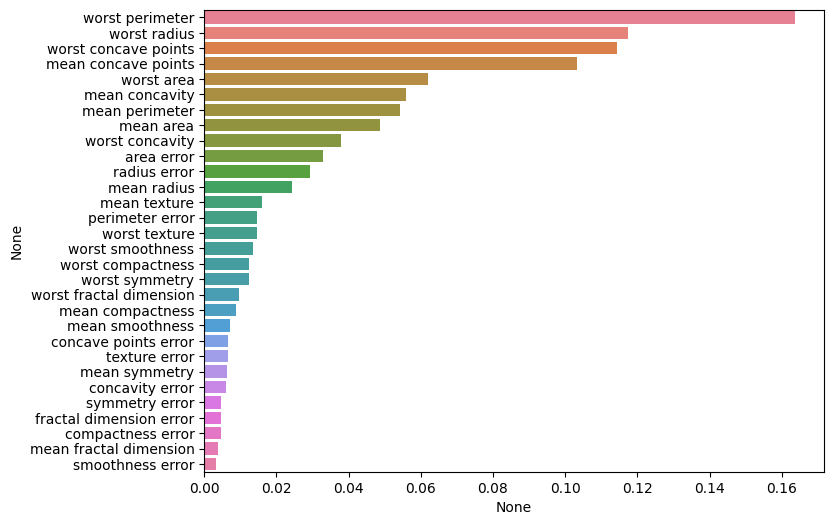

In [12]:
# 특성 중요도 시각화 
plt.figure(figsize=(8, 6))
sns.barplot(
    x=feat_imptc_ser,
    y=feat_imptc_ser.index,
    hue = feat_imptc_ser.index
)

---

### [실습] 인간행동인식 다중분류


https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones 

사용자 행동 target class
- WALKING
- WALKING_UPSTAIRS
- WALKING_DOWNSTAIRS
- SITTING
- STANDING
- LAYING

**HAR 특성 설명**

| **특성 유형**             | **설명**                                                                                                                                     |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------------------------|
| **Mean와 Std**            | 'tBodyAcc-mean()-X', 'tBodyAcc-std()-Y'와 같은 특성은 시간 도메인에서의 신체 가속도에 대한 평균 및 표준편차 값 ('X', 'Y', 'Z'는 축을 의미) |
| **주파수 도메인 특징**     | 이름에 'f'로 시작하는 특성은 주파수 도메인에서 계산된 값 (예를 들어 'fBodyAcc-meanFreq()-X'는 신체 가속도 센서의 X축에서의 평균 주파수 값)    |
| **가속도와 자이로스코프 데이터** | 'tBodyAcc', 'tGravityAcc', 'tBodyGyro' 등의 특성은 신체 가속도, 중력 가속도, 자이로스코프 데이터                                                  |
| **Jerk 신호**             | 'tBodyAccJerk-mean()-X'와 같은 특성은 가속도의 변화율 (활동 간의 차이를 분류하는 데 중요한 역할)                                          |
| **Magnitude(크기)**       | 'tBodyAccMag-mean()', 'tGravityAccMag-std()'와 같은 특성은 특정 축 방향의 가속도 또는 자이로스코프 값을 합친 크기                                             |
| **FFT 변환 기반 특징**    | 주파수 도메인에서의 데이터 특성들은 Fourier 변환을 통해 얻어짐 (예를 들어, 'fBodyAccMag-mean()'은 주파수 도메인에서 가속도의 크기의 평균값)                  |
| **Angle(각도)**           | 'angle(X,gravityMean)'과 같은 특성은 특정 축과 중력 벡터 간의 각도 (중력과의 상대적인 위치 나타냄)                                                    |
| **레이블**                | 'Activity' 컬럼에는 각 행의 활동 레이블이 포함 (걷기, 계단 오르기, 계단 내리기, 앉기, 서기, 눕기 등의 활동 종류 있음)                                          |


0.9804134929270947
0.9114353579911775


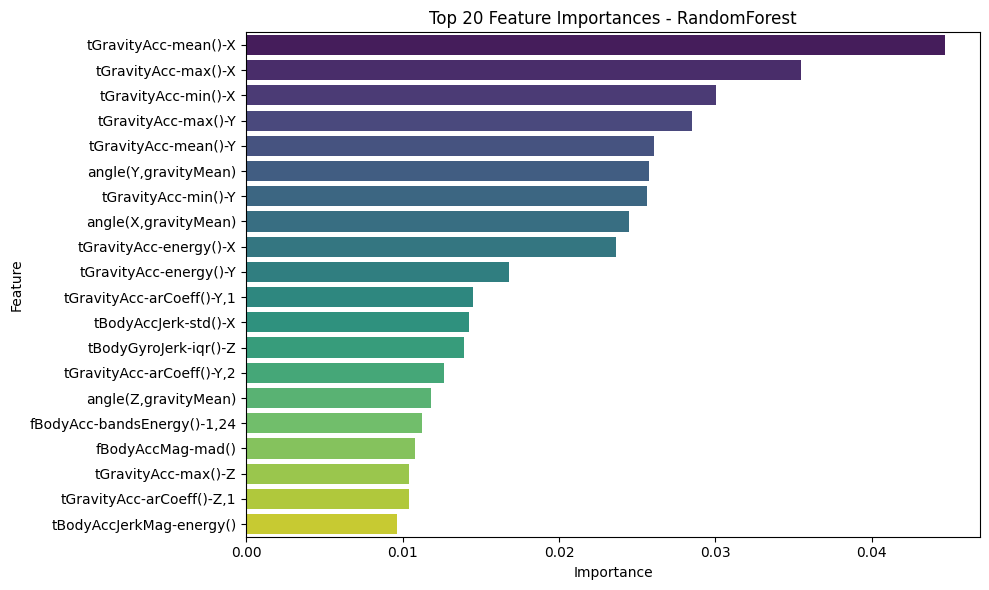

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 1. 데이터 로드
train_data = pd.read_csv('data/har_train.csv')
test_data = pd.read_csv('data/har_test.csv')
train_data.shape, test_data.shape

# 2. 데이터 분리
X_train = train_data.drop('Activity', axis=1)
y_train = train_data['Activity']

X_test = test_data.drop('Activity', axis=1)
y_test = test_data['Activity']

# 3. 레이블 인코딩
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# 4. 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5. RandomForestClassifier 모델 학습
rf = RandomForestClassifier(n_estimators= 100 ,random_state=42, max_depth=7)
rf.fit(X_train, y_train)

# 6. 모델 예측
print(rf.score(X_train, y_train))
# print(rf.score(X_test, y_test))

# 7. 예측
y_pred = rf.predict(X_test)

# 8. 평가(정확도)
print(accuracy_score(y_pred, y_test))

# 9. 중요도 상위 20개의 특성 시각화
feat_imptc_ser = pd.Series(rf.feature_importances_, index=train_data.drop('Activity', axis=1).columns).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=feat_imptc_ser,
    y=feat_imptc_ser.index,
    palette='viridis'  # 컬러맵을 정해주면 가독성↑
)

plt.title('Top 20 Feature Importances - RandomForest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Boosting
- 깊이가 얕은 결정트리를 사용해 이전 트리의 오차를 보정하는 방식
- 순차적으로 경사하강법을 사용해 이전 트리의 오차를 줄여나감
    - 분류 모델에서는 손실함수 Logloss를 사용해 오차를 줄임
    - 회귀모델에서는 손실함수 MSE를 사용해 오차를 줄임
- Boosting 계열은 일반적으로 결정트리 개수를 느려도 과적합에 강함
- 대표적인 알고리즘(모델): GradientBoosting, HistGradientBoosting, XGBoosting(DMLC), LightGBM(MS). CatBoost

##### GradientBoosting 구현

In [14]:
from sklearn.tree import DecisionTreeRegressor

In [15]:
class SimpledGradientBoostingClassifier:
    
    def __init__(self, n_estimastors=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimastors
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.initial_log_odds = 0   # 초기 예측값
        self.trees = [] # estimator 모음 배열
        
    def log_odds(self, p):
        # 확률값 -> 로진 변환: 0~1 사이의 값을 펼쳐 -무한대~+무한대 사이의 값으로 보정
        return np.log(p/(1-p))
        
    def sigmoid(self, z):
        # z값 -> 0~1 사이의 확률 값 변환
        return 1/ (1+np.exp(-z))    
    
    def fit(self, X, y):
        # 초기 예측값 설정
        y_mean = np.mean(y)
        self.initial_log_odds = self.log_odds(y_mean)
        y_pred_log_odds = np.full_like(y, self.initial_log_odds, dtype=np.float64)
        
        # 모델 생성 및 학습
        for _ in range(self.n_estimators):
            # 현재 상태에서 예측된 확률값 계산
            y_pred_proda = self.sigmoid(y_pred_log_odds)
            
            # 잔차 계산
            residual = y - y_pred_proda
            
            # 결정 트리 생성 및 학습
            tree = DecisionTreeRegressor(max_depth=self.max_depth)       
            tree.fit(X,residual)    # 전차를 라벨로 학습
            self.trees.append(tree)
            
            #예측값 업데이트 (예측값 점진적 개선)
            y_pred_log_odds += self.learning_rate * tree.predict(X)
              
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)
        
    def predict_proba(self, X):
        y_pred_log_odds = np.full((X.shape[0],), self.initial_log_odds)
        
        # 트리의 예측값을 누적하여 최종 로직값 계산
        for tree in self.trees:
            y_pred_log_odds += self.learning_rate * tree.predict(X)
            
        return self.sigmoid(y_pred_log_odds)

In [16]:
# SimpledGradientBoostingClassifier로 유방암 데이터 예측


# 데이터를 로드 분리 
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0)

# 모델 새성
simpple_gb_clf = SimpledGradientBoostingClassifier(
    n_estimastors=100,
    learning_rate=0.1,
    max_depth=5
)

simpple_gb_clf.fit(X_train, y_train)

y_pred_train = simpple_gb_clf.predict(X_train)
y_pred_test = simpple_gb_clf.predict(X_test)

print(f"학습 정확도: {accuracy_score(y_train, y_pred_train)}")
print(f"평가 정확도: {accuracy_score(y_test, y_pred_test)}")


학습 정확도: 0.9953051643192489
평가 정확도: 0.916083916083916


___

##### GradientBoosting

In [17]:
# GradientBoostingClassifier로 유방암 데이터 예측
from sklearn.ensemble import GradientBoostingClassifier
# 데이터 로드 및 분리 
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0)

# 모델 생성
gb_clf = GradientBoostingClassifier(
    n_estimators = 100,
    learning_rate = 0.01,
    max_depth=3
)

# 학습
gb_clf.fit(X_train, y_train)

y_pred_train = gb_clf.predict(X_train)
y_pred_test = gb_clf.predict(X_test)

print(f"학습 정확도: {accuracy_score(y_train, y_pred_train)}")
print(f"평가 정확도: {accuracy_score(y_test, y_pred_test)}")
# 예측 및 평가

학습 정확도: 0.9882629107981221
평가 정확도: 0.958041958041958


##### HistGradientBoossting
- 고성능 GradientBoosting 모델로 대규모 데이터셋 처리에 적합
- Histogram 기반으로 256개의 구간으로 나누어 처리 병합하는 방식
- 결측치가 있어도 전처리 필요 없음
- LightGBM의 영향을 받아 만들어진 scikit_learn의 모델

In [18]:
from sklearn.ensemble import HistGradientBoostingClassifier

data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=42)

hist_gb_clf = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    max_bins=255,           # 255개의 구간으로 나누어 처리
    early_stopping=True,    # 반복 중 '일정 횟수'이상 성능 향상아 없으면 학습 종료
    n_iter_no_change=5      # '알정 횟수' 자정(기본값: 10)
)

hist_gb_clf.fit(X_train, y_train)

y_pred_train = hist_gb_clf.predict(X_train)
y_pred_test = hist_gb_clf.predict(X_test)

print(f"학습 정확도: {accuracy_score(y_train, y_pred_train)}")
print(f"평가 정확도: {accuracy_score(y_test, y_pred_test)}")

학습 정확도: 0.9976525821596244
평가 정확도: 0.958041958041958


In [19]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    hist_gb_clf,
    X_train,
    y_train,
    n_repeats=5,
    random_state=0
)
# importances_mean: 평균 중요도
# importance_std: 중요도 표준편차
# importance: 특성 중요도
result.importances_mean

array([0.00093897, 0.00938967, 0.        , 0.00140845, 0.00093897,
       0.        , 0.        , 0.00798122, 0.        , 0.        ,
       0.00234742, 0.        , 0.        , 0.00610329, 0.        ,
       0.00469484, 0.        , 0.        , 0.00140845, 0.        ,
       0.0028169 , 0.0084507 , 0.        , 0.0056338 , 0.00140845,
       0.        , 0.01032864, 0.02957746, 0.        , 0.        ])

##### 회귀모델

`sklearn.datasets.load_diabetes` 데이터셋
- 당뇨병 환자의 진단 자료를 바탕으로 만들어진 회귀용 데이터셋

**데이터셋 설명:**
- **목적**: 당뇨병 진행 정도(1년 후)를 예측
- **데이터 수**: 442개의 샘플
- **특성 수**: 10개의 특성 (10개의 입력 변수)
- **타겟**: 연속형 값, 당뇨병의 1년 후 진행 상황을 나타냄

**특성 설명:**
데이터셋의 각 특성(피처)은 환자의 다양한 생체 정보

1. **age**: 나이 (Age)
2. **sex**: 성별 (Sex)
3. **bmi**: 체질량 지수 (Body Mass Index)
4. **bp**: 평균 혈압 (Average Blood Pressure)
5. **s1**: 혈청 내 TC (Total Cholesterol)
6. **s2**: 혈청 내 LDL (Low-Density Lipoproteins)
7. **s3**: 혈청 내 HDL (High-Density Lipoproteins)
8. **s4**: 혈청 내 TCH (Total Cholesterol / HDL)
9. **s5**: 혈청 내 LTG (Log of Serum Triglycerides)
10. **s6**: 혈당 수치 (Blood Sugar Level)

**데이터 구조:**
- **입력 데이터 (data)**: (442, 10) 크기의 NumPy 배열
- **타겟 데이터 (target)**: (442,) 크기의 NumPy 배열로, 각 샘플의 타겟 값(연속형 값)을 포함

In [20]:
from sklearn.datasets import load_diabetes

diabates = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(diabates.data, diabates.target, random_state=0)

In [21]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

hist_gb_reg = HistGradientBoostingRegressor(
    max_iter= 200,
    max_depth=1,
    learning_rate=0.1,
    random_state=0,
    l2_regularization=0.1,
    max_bins= 127,
    min_samples_leaf=20
)

hist_gb_reg.fit(X_train, y_train)

y_pred_train = hist_gb_reg.predict(X_train)
y_pred_test = hist_gb_reg.predict(X_test)

print(f'학습 MSE: {mean_squared_error(y_train, y_pred_train)} | 학습 R2: {r2_score(y_train, y_pred_train)}')
print(f'평가 MSE: {mean_squared_error(y_test, y_pred_test)} | 학습 R2: {r2_score(y_test, y_pred_test)}')

학습 MSE: 2168.8165397973044 | 학습 R2: 0.6531821395516976
평가 MSE: 3454.788040736414 | 학습 R2: 0.30408940165794296


In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_iter': [100, 200, 300],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.01,0.05, 0.1],
    'min_samples_leaf': [10, 20, 30],
    'l2_regularization': [0.01, 0.1, 1.0],
    'max_bins': [255, 127]
}
hist_gb_reg = HistGradientBoostingRegressor(random_state=0)
grid_search = GridSearchCV(hist_gb_reg, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

grid_search.best_params_    # 최고의 성능을 내는 하이퍼 파아미터

KeyboardInterrupt: 

In [144]:
best_hist_gb_reg = grid_search.best_estimator_
# best_hist_gb_reg

y_pred_train = best_hist_gb_reg.predict(X_train)
y_pred_test = best_hist_gb_reg.predict(X_test)

print(f'학습 MSE: {mean_squared_error(y_train, y_pred_train)} | 학습 R2: {r2_score(y_train, y_pred_train)}')
print(f'평가 MSE: {mean_squared_error(y_test, y_pred_test)} | 학습 R2: {r2_score(y_test, y_pred_test)}')

학습 MSE: 2168.8165397973044 | 학습 R2: 0.6531821395516976
평가 MSE: 3454.788040736414 | 학습 R2: 0.30408940165794296
